# The Computational Image of the City: Landmarks
Four scores are here computed to extract computation landmarks: structural, visual, cultural, pragmatic.
Currently, the user has to provide the building shapefile, collected independently. The height is the only necessary field, plus two datasets containing respectively information about cultural/historical landmarks (e.g. position of listed important buildings) and land-use.

In [2]:
import matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import matplotlib.pyplot as plt
from importlib import reload
import functools
import time
%matplotlib inline

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

In [7]:
import landmarks_functions as lf
import utilities as uf

In [94]:
reload(uf)

<module 'utilities' from 'C:\\Users\\g_filo01\\sciebo\\scripts\\Image of the City\\utilities.py'>

## Loading the data

In [ ]:
"""
specify coordinates and directories
'buildings_all' is the large buiding datasets. Landmarks are extracted from buildings that are within the 'area_to_clip'
(the case study area). Some buildings around the case study area have to be included in the analys in order to compute measures
correctly, without mistakenly exalting building at the edges. If no 'area_obstructions' (an area larger than the case study)
is provided the function extracts building in a buffer of 800 mt around the case study. 'height_field'and 'base_field' are to be
used to indicate the maximum and the base height field of the buildings, in the original shapefile. When the second
is not provided, the base is automatically set to 0. Height is necessary to perform the landmark extraction.

Buildings smaller then 200 square meters are kept out of the analysis, as well as buildgins whose height is lower than 1mt.
"""
city_name = 'London'

if city_name == 'Boston':
    epsg = 26986
    crs = {'init': 'epsg:26986', 'no_defs': True}
    
    buildings_all = gpd.read_file('C:/Users/g_filo01/sciebo/Scripts/Tools/Outputs/bh_2002_26986.shp').to_crs(epsg=epsg)
    area_to_clip = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/city_center_buffer_100.shp').to_crs(epsg=epsg)
    area_obstructions = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/buffer_4000.shp').to_crs(epsg=epsg)

    buildings, obstructions = lf.select_buildings(buildings_all, area_to_clip, height_field = 'ROOF', base_field = 'GND', 
                                                  area_obstructions = area_obstructions)
    obstructions.to_file(driver='ESRI Shapefile', filename= "Outputs/tmp/"+city_name+"/"+city_name+"_obstructions.shp")
    
elif city_name == 'London':
    epsg = 27700
    crs = {'init': 'epsg:27700', 'no_defs': True}

    buildings_all = gpd.read_file("C:/Users/g_filo01/sciebo/GIS Data/London/Buildings/London_buildings_all.shp")
    area_to_clip = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/Congestion_area_polygon/Polygon.shp')

    buildings, obstructions = lf.select_buildings(buildings_all, area_to_clip, 'max', base_field = None)
    obstructions.to_file(driver='ESRI Shapefile', filename= "Outputs/tmp/"+city_name+"/"+city_name+"_obstructions.shp")

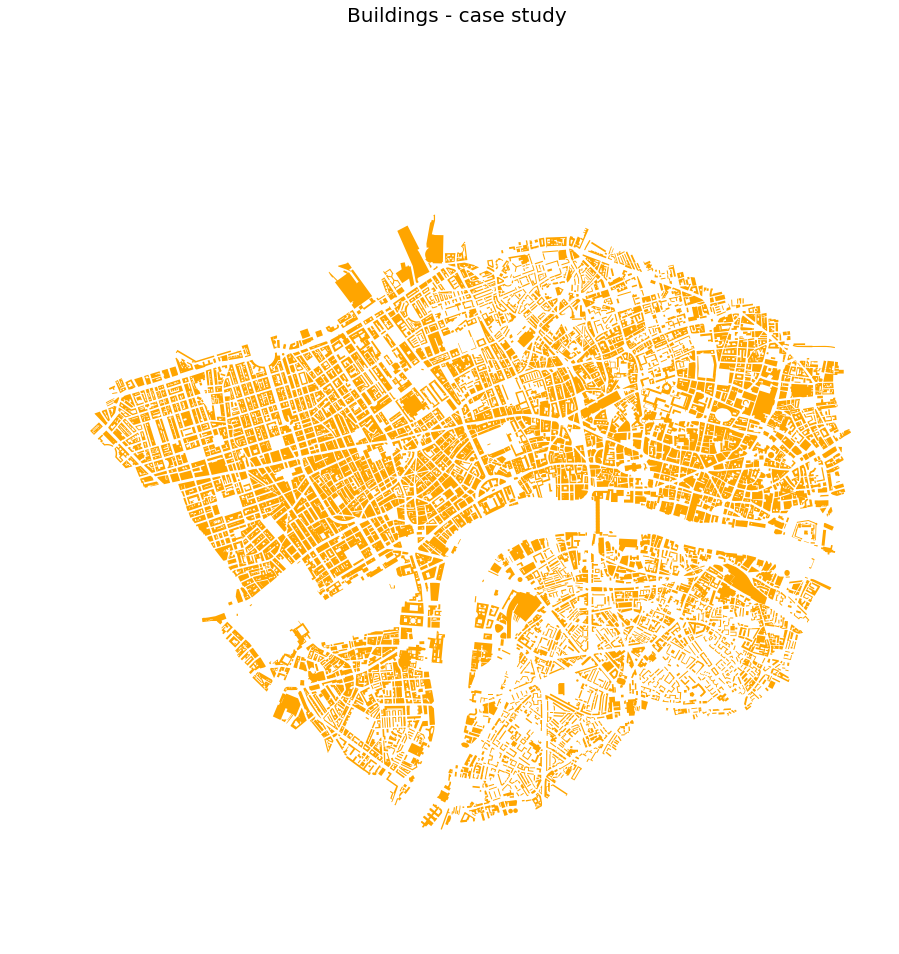

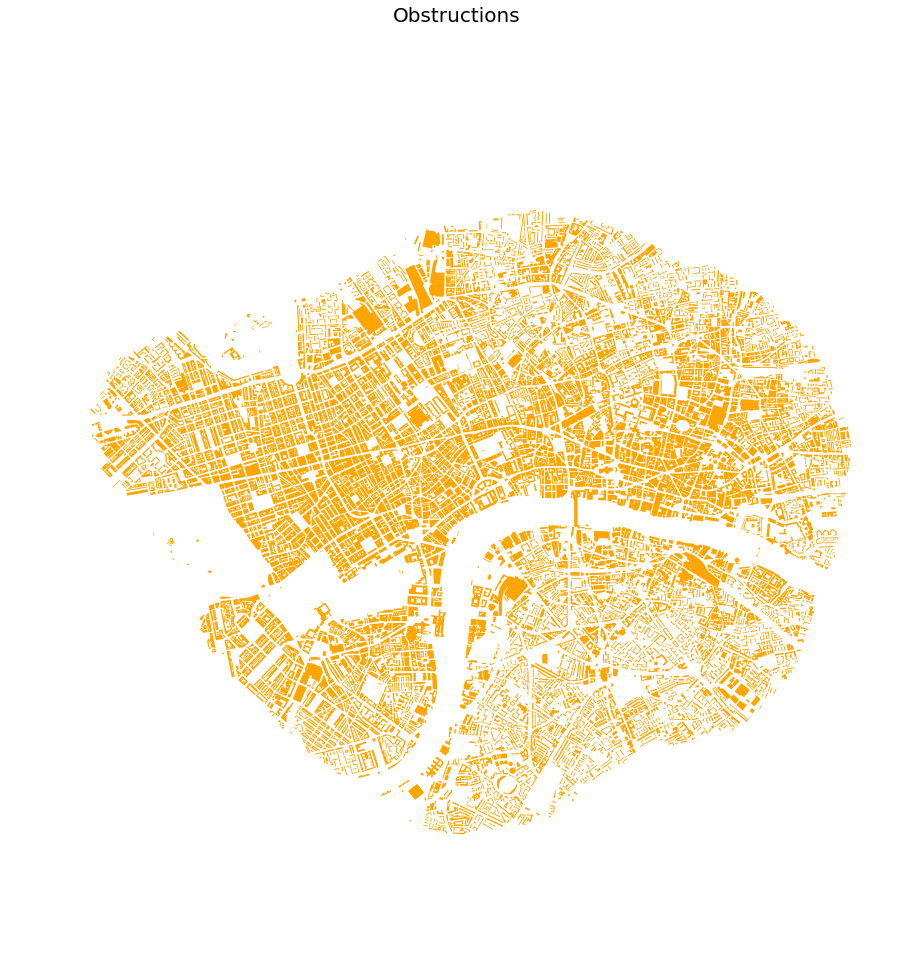

In [90]:
# visualising
uf.plot_polygons(buildings, title = 'Buildings - case study', bb = False, f =15)
uf.plot_polygons(obstructions, title = 'Obstructions', bb = False, f =15)

## 1 - Structural component

In [40]:
%%time

# reading the street network and passing it in the function to compute the structural score
streets = gpd.read_file("Outputs/"+city_name+"/"+city_name+"_paths.shp")

"""
computes:
- distance from the road
- number of adjacent buildings 
* area was already computed
** computes also façade area, a measure included in the visibility score
"""

# The 'buffer' parameter indicates distance within the algorithms look for neighbouring buildings
buildings = lf.structural_properties(buildings, obstructions, streets, buffer = 150)

Wall time: 1min 11s


In [23]:
%%time

#  compute 2d advance visibility (a sort of visibility buffer around the building - maximum radium is 2000 mt)
buildings, vis = lf.advance_visibility(buildings, obstructions, radius = 500)

progress: 99 %Wall time: 2h 52s


## 2 - Visual component

In [46]:
# saving a temporary file that will be used for constructing the sightlines
buildings.to_file(driver='ESRI Shapefile',filename = "Outputs/tmp/"+city_name+"/"+city_name+"_buildings_sight.shp")

In [ ]:
# leave the notebook and run the script sight_lines.py within ArcGis Pro (should work in ArcScene too)

In [138]:
# loading the sight_lines file
sight_lines = gpd.read_file("Outputs/"+city_name+"/"+city_name+"_visible_sl.shp")
sight_lines.head()

Shape_Leng  Visible  buildingID  nodeID  \
0     989.365        1       27131      10   
1     938.480        1       27131      10   
2     935.026        1       27131      10   
3     950.623        1       27131      10   
4     980.518        1       27131      10   

                                            geometry  
0  LINESTRING (528249.0162000023 182138.709600003...  
1  LINESTRING (528249.0162000023 182138.709600003...  
2  LINESTRING (528249.0162000023 182138.709600003...  
3  LINESTRING (528249.0162000023 182138.709600003...  
4  LINESTRING (528249.0162000023 182138.709600003...

In [144]:
# computing the visibility score
buildings = lf.visibility(buildings, sight_lines)

## 3 - Cultural component

In [41]:
%%time

"""
Loading historical polygons and computing cultural score.
The  'Grade' column is used on the basis on an existing rank (data-dependent).
If no classification is available from the data source, run the function without the 'score' argument.
"""

if city_name == 'Boston':
    directoryBoston = "C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/historic_landmarks.shp"
    cultural_elements = (gpd.read_file(directoryBoston)).to_crs(epsg=epsg)
    buildings = ic.cultural_meaning(buildings, cultural_elements)

if city_name == 'London':
    directoryLondon = "C:/Users/g_filo01/sciebo/GIS Data/London/Historic_England/Listed_building_selection.shp"
    cultural_elements = (gpd.read_file(directoryLondon)).to_crs(epsg=epsg)
    cultural_elements['Grade'] = cultural_elements['Grade'].map( lambda x: 3 if x == 'I' else 2 if x == 'II*' else 1 
                                       if x == 'II' else 0)
    buildings = lf.cultural_meaning(buildings, cultural_elements, score = 'Grade')

Wall time: 5.86 s


## 4 - Pragmatic component

Here different land-use datasets are loaded to assign land-use categorisation to the *buildings* GDF. At the moment this part is city-dependent. The pragmatic score is computed on the large area (*obstructions* GDF) to take into account adjacent buildings also along the edge of the case-study area. The method here used to assign land-use descriptors to the main GDF is based on geometries intersection. From polygons GDFs: Tha land-use of the building *x* in the external GDF is assigned to the building *y* from the *buildings* GDF, only when the intersection area cover 60% of *y*. From points GDFs: simple intersection.

### London

In [50]:
# polygons
"""
Important buildings, functional sites, public tranport stations shapefiles from Ordnance Survey are loaded.
OpenStreetMap building shapefile is loaded too before a point file with Point of Interest in London (Ordnance Survey)
"""
imp = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/TQ_ImportantBuilding2.shp').to_crs(epsg = epsg)
fs = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/TQ_FunctionalSite.shp').to_crs(epsg = epsg)
stations = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/TQ_RailwayStation.shp').to_crs(epsg = epsg)
osm_buildings = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OSM/buildings.shp').to_crs(epsg = epsg)
osm_buildings = osm_buildings[osm_buildings['type'] != None]

# points
POI = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/London_POI.shp').to_crs(epsg = epsg)

In [ ]:
%%time

# provide 3 lists:  names of the GDFs loaded; the field where land-use information is contained; name of the new_columns

gdf = [imp, fs, stations, osm_buildings] 
columns_lu = ['BUILDGTHEM', 'SITETHEME', 'CLASSIFICA', 'type']
new_columns = ['land_use_1', 'land_use_2', 'land_use_3', 'land_use_4']

# extracting land-use information from all the GDFs
for i, p in enumerate(gdf): obstructions = lf.land_use_from_polygons(obstructions, p, new_columns[i], columns_lu[i])

In [62]:
%%time
# same procedure for all the Point-file loaded
gdf = [POI]
columns_lu = ['main']
new_columns = ['land_use_5']

for i, p in enumerate(gdf): obstructions = lf.land_use_from_points(obstructions, p, new_columns[i], columns_lu[i])

Wall time: 14.3 s


In [63]:
"""
Please establish a hierarchy. In this case, for example, 'land_use_4' is used only when all the others land-use columns
are empty. 'land_use_1' is supposed to have priority over the others (when filled).
"""

obstructions['land_use_1'][obstructions['land_use_1'].isnull()] = obstructions['land_use_2']
obstructions['land_use_1'][obstructions['land_use_1'].isnull()] = obstructions['land_use_3']
obstructions['land_use_1'][obstructions['land_use_1'].isnull()] = obstructions['land_use_5']
obstructions['land_use_1'][obstructions['land_use_1'].isnull()] = obstructions['land_use_4']
obstructions.head()

height  base     area  buildingID  \
0   3.180     0  208.221           0   
1  12.210     0  942.013           0   
2  12.270     0  331.740           0   
3  27.820     0 1637.525           0   
4  11.590     0 1441.718           0   

                                            geometry           land_use_1  \
0  POLYGON ((529891.7900001183 183628.2199995402,...            Transport   
1  POLYGON ((529908.4400001189 183173.1599995393,...                 None   
2  POLYGON ((529866.5000001183 183238.34999954, 5...  Commercial services   
3  POLYGON ((527543.2900001081 182478.7399995871,...          Attractions   
4  POLYGON ((527005.8700001058 182333.7399995989,...            Education   

  land_use_2 land_use_3 land_use_4            land_use_5  
0        NaN        NaN        NaN             Transport  
1        NaN        NaN       None                   NaN  
2        NaN        NaN       None   Commercial services  
3        NaN        NaN        NaN           Attractions  
4  Education        NaN        NaN  Education and health

In [ ]:
"""
This function reclassify the land-use descriptors in pre-defined categories (see the script landmark_functions.py for more 
details). It usually works for OSM data. Edit the source for including other land-use descriptors. Please indicate the main
land_use field.
"""
obstructions = lf.classsify_lu(obstructions, 'land_use_1')
obstructions['land_use'] = obstructions['land_use_1']
obstructions.drop(['land_use_1', 'land_use_2', 'land_use_3', 'land_use_4', 'land_use_5'], axis = 1, inplace = True)

### Boston

In [ ]:
# Loading polygons data: parcel from Boston Open Data Portal, buildings from OpenStreetMap

parcels = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/Parcels_2016/parcels.shp').to_crs(epsg = epsg)
osm_buildings = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/OSM/buildings.shp').to_crs(epsg = epsg)
osm_buildings = osm_buildings[osm_buildings['type'] != None]

In [ ]:
%%time

# provide 3 lists:  names of the GDFs loaded; the fields where land-use information is contained; name of the new_columns

gdf = [parcels, osm_buildings]
columns_lu = ['LU', 'type']
new_columns = ['land_use_1', 'land_use_2']
for i, p in enumerate(gdf): obstructions = lf.land_use_from_polygons(obstructions, p, new_columns[i], columns_lu[i])
obstructions['land_use_1'][obstructions['land_use_1'].isnull()] = obstructions['land_use_2']
obstructions = lf.classsify_lu(obstructions, 'land_use_1')

#### Other data

In [ ]:
# libraries, universities, schools and police stations

schools = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/schools.shp').to_crs(epsg=epsg)
uni = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/universities.shp').to_crs(epsg=epsg)
p_schools = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/p_schools.shp').to_crs(epsg=epsg)
lib = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/libraries.shp').to_crs(epsg=epsg)
pools = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/pools.shp').to_crs(epsg=epsg)
police = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/police.shp').to_crs(epsg=epsg)

In [ ]:
%%time

"""
Land-use-specific datasets are also used.
When the 'land_use_1' field in the 'obstructions' GDF is still empty or only filled with 'residential' or 'commercial' values,
the land-use-specific GDFs are used to fill in the field (when geometries intersect).
"""

df_list = [schools, p_schools, libraries, universities, pools, police]
classification = ['education', 'education', 'library', 'university', 'sport', 'emergency_service']
list_ignore = ['residential', 'commercial', None]

index_geometry = obstructions.columns.get_loc("geometry")+1 
index_land_use = obstructions.columns.get_loc("land_use_1")+1

# iterate through the specif GDF and replace land-use information

for i, t in enumerate(df_list):
    sindex = t.sindex # spatial index

    for row in obstructions.itertuples():
        g = row[index_geometry] # geometry
        possible_matches_index = list(sindex.intersection(g.bounds))
        possible_matches = t.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.intersects(g)]
                
        if (len(precise_matches)==0): continue # buildings don't intersect
        if (row[index_land_use] not in list_ignore): continue # if there's already a land-use value continue
        else: obstructions.set_value(row[0], 'land_use_1', classification[i])

In [ ]:
obstructions['land_use'] = obstructions['land_use_1']
obstructions.drop(['land_use_1', 'land_use_2', 'land_use_3', 'land_use_4', 'land_use_5'], axis = 1, inplace = True)
obstrucions.head()

### Pragmatic meaning computation

In [66]:
%%time

"""
Computing the pragmatic score and assigning it to 'buildings_gdf'.
The pragmatic component is computed on the 'obstructions' GDF as the measure considers adjacent buildings' land_use
The 'buffer' parameter indicates the extension of the area that is used to compute the score of a building, on the basis of
its land-use's frequency, in an area of 'buffer' meters around it.
"""

obstructions = lf.pragmatic_meaning(obstructions, buffer = 200)
buildings = pd.merge(buildings, obstructions[['prag', 'land_use', 'buildingID']], how = 'left', 
                     left_on = "buildingID", right_on = "buildingID")

Wall time: 32.8 s


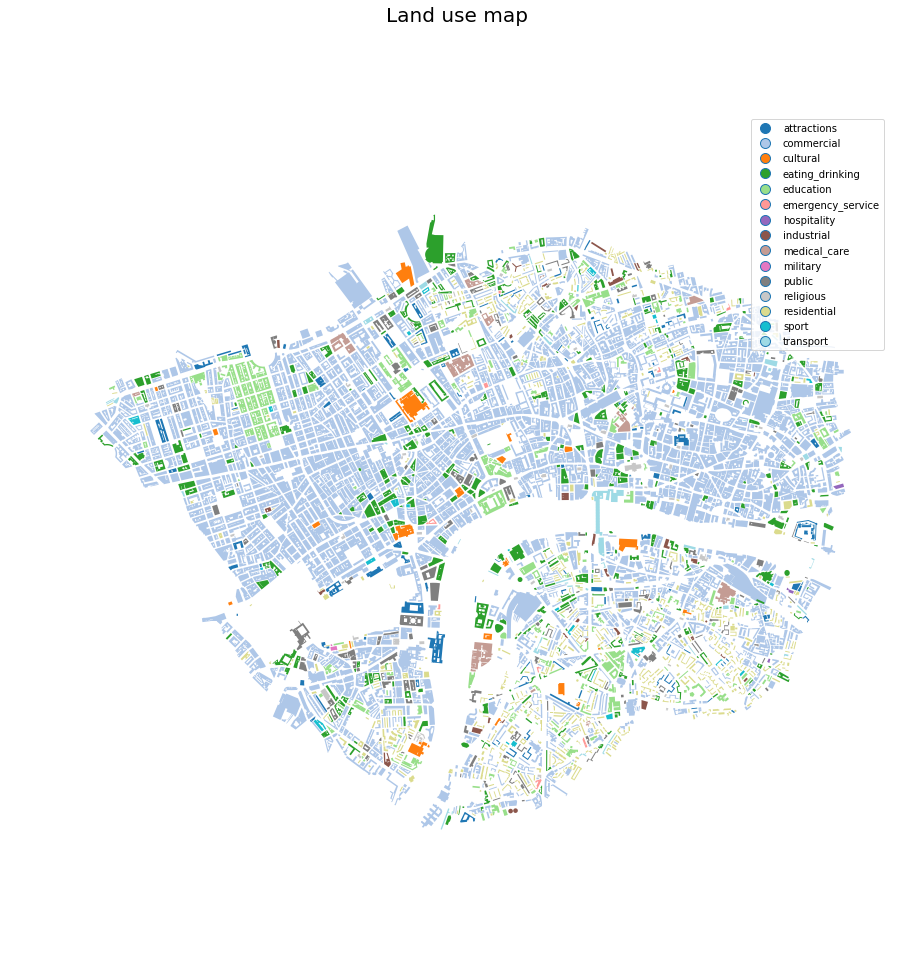

In [160]:
# visualising
uf.plot_polygons(buildings, column = 'land_use', cmap = 'tab20', title = 'Land use', bb = False, f = 15, legend = True)

# 5 - Final scores

In [172]:
%%time

# Global and Local Score (800 mt area)

buildings = lf.compute_scores(buildings)
buildings = lf.local_scores(buildings, 800)
buildings.crs = crs
buildings.head()

Wall time: 130 ms


a_vis    area  base  buildingID      fac  height  neigh  r_height  \
0 406289.254 568.261     0       13472 1640.797 100.910  4.000   100.910   
1  25874.887 244.921     0       14303  374.247  16.805 19.000    16.805   
2 165133.567 456.620     0       14313  169.216  12.800 12.000    12.800   
3  33416.213 385.922     0       14314  293.025  18.257 12.000    18.257   
4 267367.536 315.001     0       14315   85.235   5.172 11.000     5.172   

    road  cult    ...      road_sc vScore  sScore  vScore_sc  sScore_sc  \
0  5.253     0    ...        0.942  0.351   0.633      0.355      0.868   
1  0.925     0    ...        0.990  0.077   0.385      0.078      0.428   
2 16.517     0    ...        0.817  0.161   0.448      0.163      0.540   
3 73.487     0    ...        0.187  0.055   0.243      0.055      0.175   
4  5.292     0    ...        0.941  0.133   0.535      0.134      0.695   

   gScore  gScore_sc                                           geometry  \
0   0.523      0.752  POLYGON ((530612.9700001215 179912.3899995261,...   
1   0.259      0.319  POLYGON ((533594.3400001363 180100.419999457, ...   
2   0.338      0.448  POLYGON ((533698.2000001371 180458.4099994547,...   
3   0.148      0.135  POLYGON ((533677.6900001373 180532.8199994561,...   
4   0.358      0.481  POLYGON ((533692.2300001374 180435.0799994554,...   

   lScore  lScore_sc  
0   0.653      0.908  
1   0.505      0.689  
2   0.574      0.791  
3   0.324      0.421  
4   0.560      0.770  

[5 rows x 37 columns]

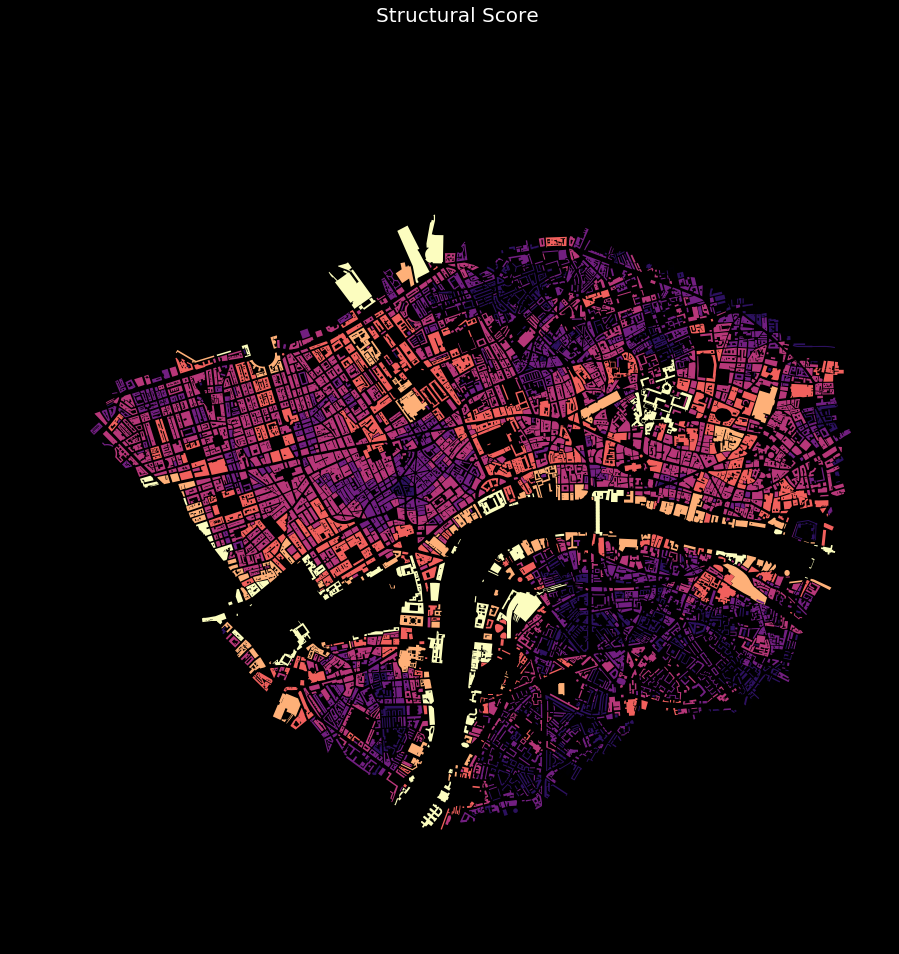

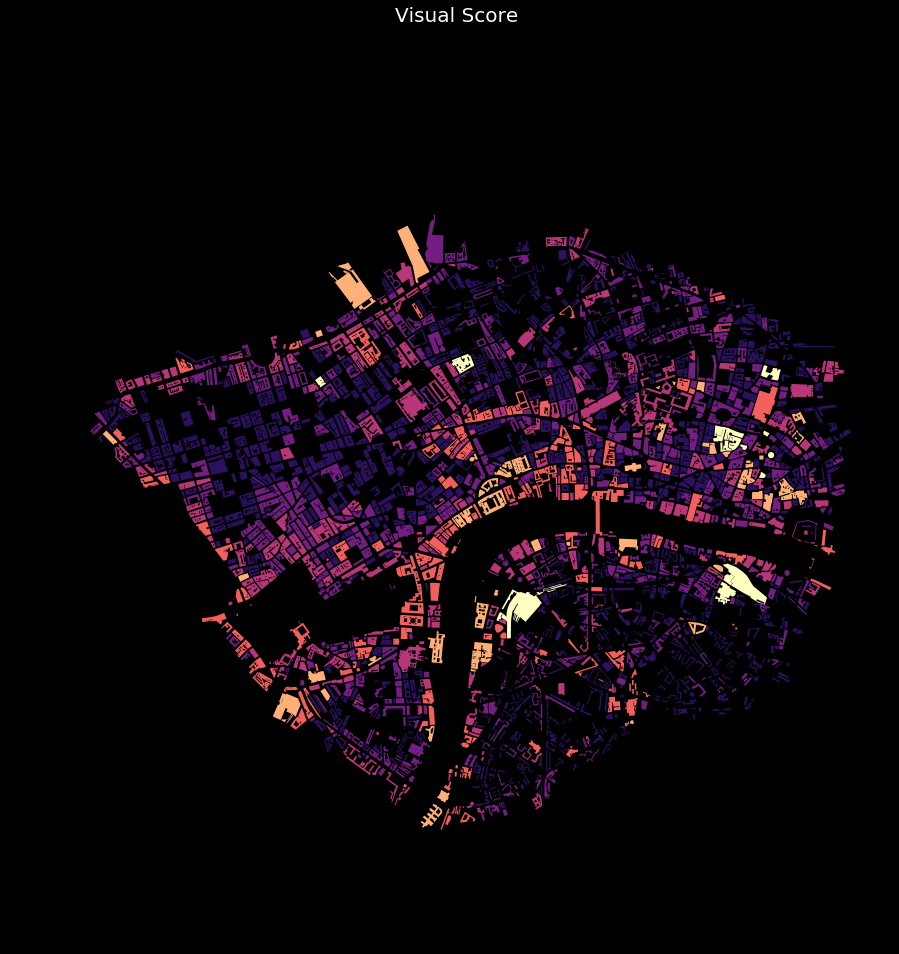

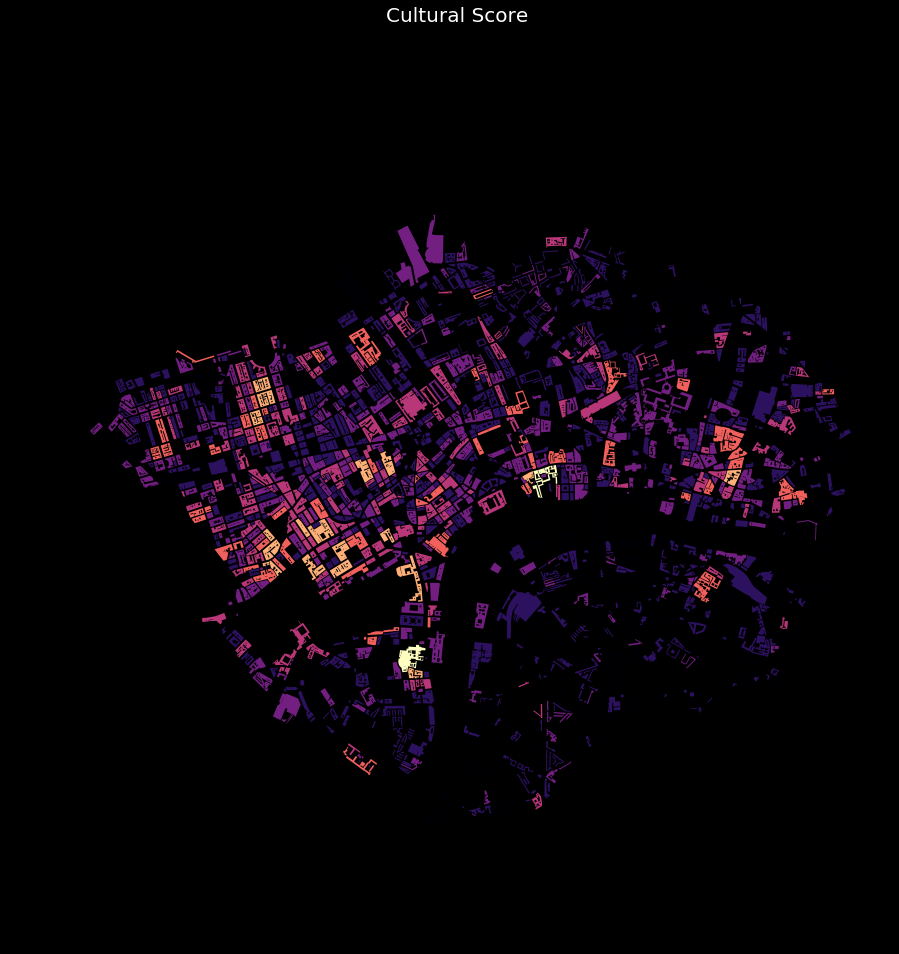

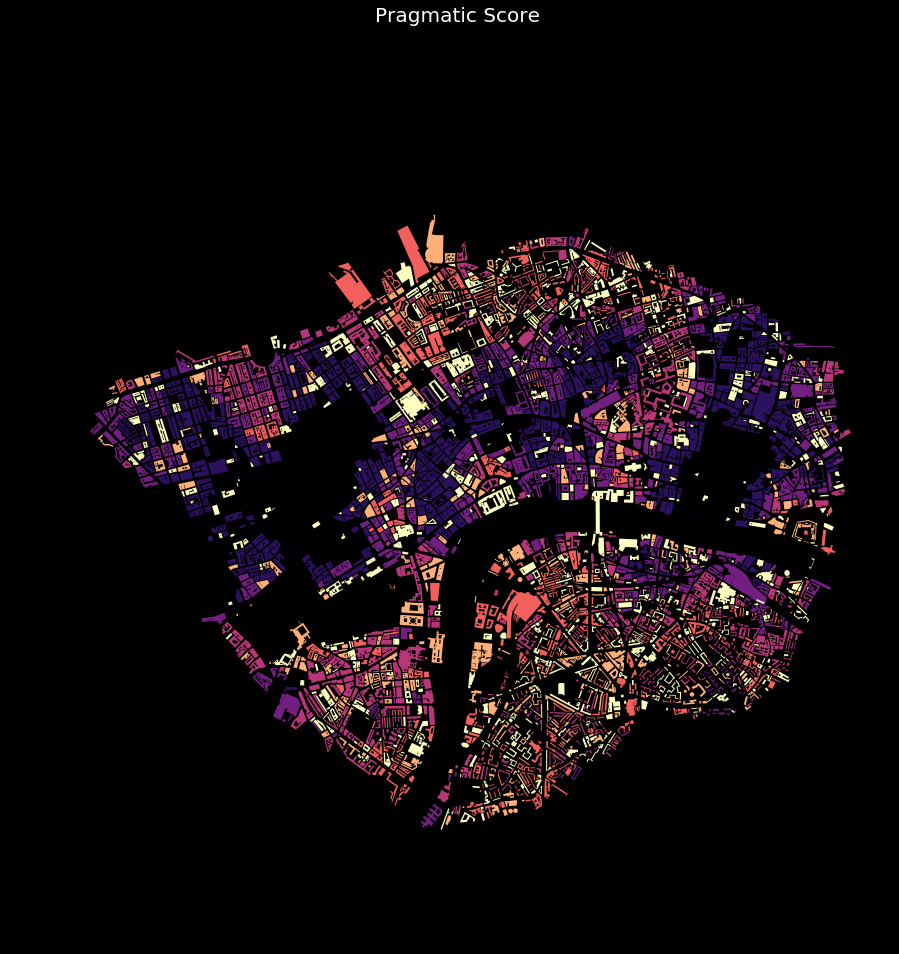

In [170]:
# visualising the four componets' maps, the color bar can be activated adding: cb = True

uf.plot_polygons(buildings, classes = 7, column = 'sScore_sc', title = 'Structural Score', 
                 scheme = 'fisher_jenks', cmap = 'magma', bb = True, cb = False, f = 15)
uf.plot_polygons(buildings, classes = 7, column = 'vScore_sc', title = 'Visual Score', 
                 scheme = 'fisher_jenks', cmap = 'magma', bb = True, cb = False, f = 15)
uf.plot_polygons(buildings, classes = 7, column = 'cult_sc', title = 'Cultural Score', 
                scheme = 'fisher_jenks',cmap = 'magma', bb = True, cb = False, f = 15)
uf.plot_polygons(buildings, classes = 7, column = 'prag_sc', title = 'Pragmatic Score', 
                scheme = 'fisher_jenks', cmap = 'magma', bb = True, cb = False, f = 15)

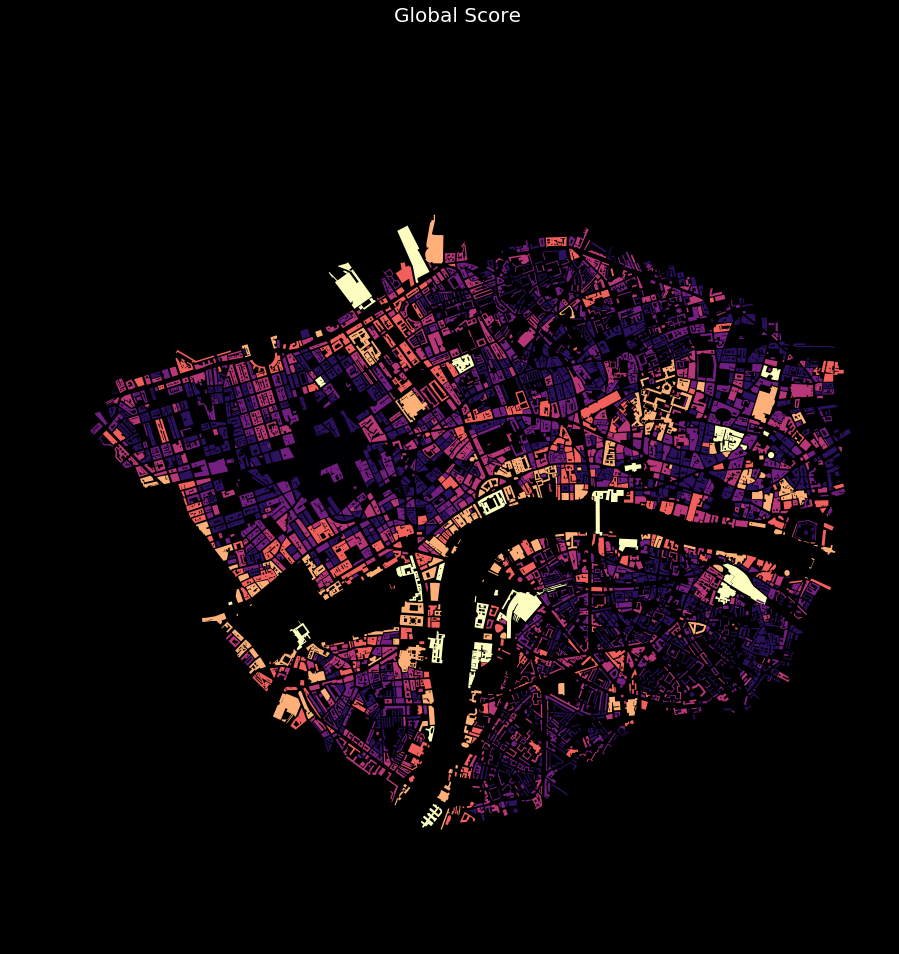

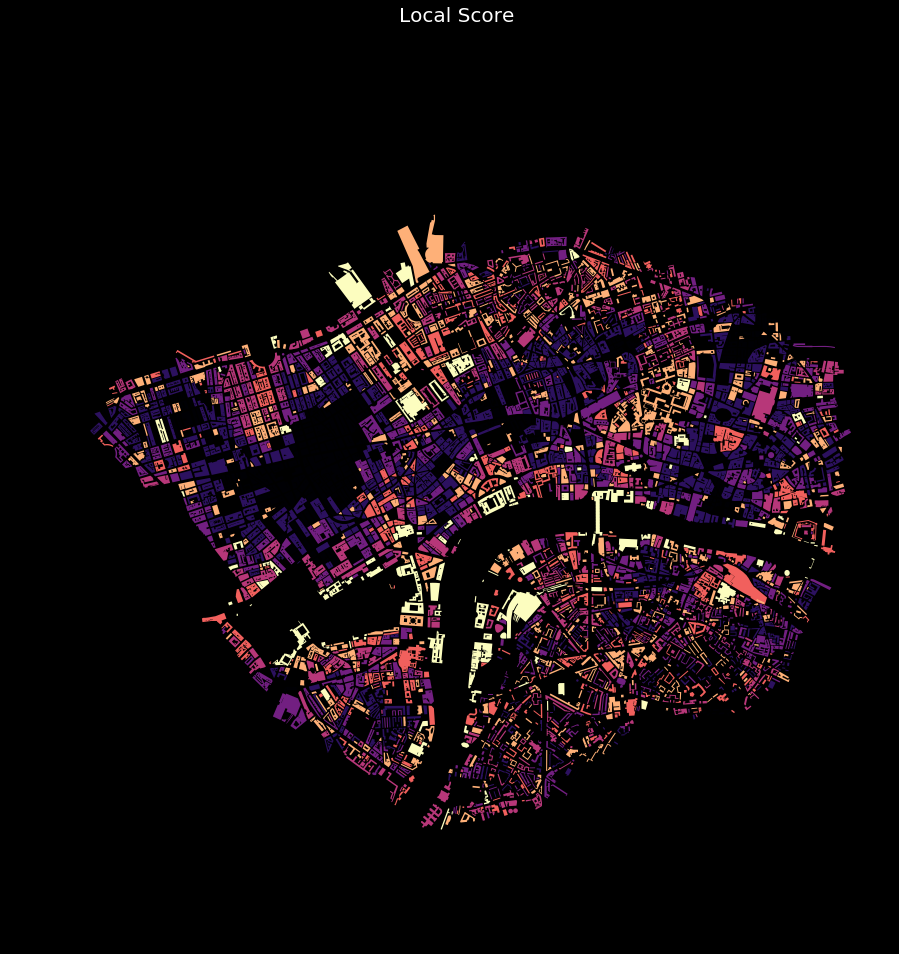

In [169]:
uf.plot_polygons(buildings, classes =7, column = 'gScore_sc', title = 'Global Score', 
                scheme = 'fisher_jenks', cmap = 'magma', bb = True, cb = False, f = 15)
uf.plot_polygons(buildings, classes =7, column = 'lScore_sc', title = 'Local Score', 
                scheme = 'fisher_jenks', cmap = 'magma', bb = True, cb = False, f = 15)